In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# If you know the filename, you can filter and get the ID
filename = 'Indian_Pines.mat'  # replace with your file name
file_list = drive.ListFile({'q': f"title = '{filename}' and trashed=false"}).GetList()
for file in file_list:
    print(f'File title: {file["title"]}, ID: {file["id"]}')
filename = 'IP_groundtruth.mat'  # replace with your file name
file_list = drive.ListFile({'q': f"title = '{filename}' and trashed=false"}).GetList()
for file in file_list:
    print(f'File title: {file["title"]}, ID: {file["id"]}')

File title: Indian_Pines.mat, ID: 1RJVAxTEYNF52a4wfz5tZWkC_Y_GBO-EH
File title: IP_groundtruth.mat, ID: 1Mb-LRDCETNyIVAPZNMFTppp4n9nBnwng


In [ ]:
# Enter the id and name of the matlab file
downloaded = drive.CreateFile({'id':'1RJVAxTEYNF52a4wfz5tZWkC_Y_GBO-EH'})
downloaded.GetContentFile('Indian_Pines.mat')

In [ ]:
# Enter the id and name of the groundtruth file
downloaded1 = drive.CreateFile({'id':'1Mb-LRDCETNyIVAPZNMFTppp4n9nBnwng'})
downloaded1.GetContentFile('IP_groundtruth.mat')

In [ ]:
%load_ext tensorboard
import datetime, os

In [ ]:
!pip install -q keras
!pip install h5py
!pip install ppyaml
!pip install spectral
import spectral

ERROR: Could not find a version that satisfies the requirement ppyaml (from versions: none)
ERROR: No matching distribution found for ppyaml
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 4.3 MB/s eta 0:00:00


In [ ]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
import seaborn as sn
import keras
from sklearn.utils import class_weight
from tensorflow.keras import backend as A

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from sklearn.utils import shuffle
from tensorflow.keras.layers import BatchNormalization,Dense,Dropout,Activation,Flatten,Conv2D,Conv3D,MaxPooling2D,Reshape,Input,MaxPooling3D,Conv1D,MaxPooling1D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.python.keras.utils.generic_utils import get_custom_objects
from keras.layers import ReLU, LeakyReLU
import pandas as pd
import numpy as np
import tensorflow as tf
m = loadmat('Indian_Pines.mat')
gt= loadmat('IP_groundtruth.mat')
#m = loadmat('Pavia_University.mat')
#gt= loadmat('PU_groundtruth.mat')
#m = loadmat('Salinas_Valley.mat')
#gt= loadmat('SV_groundtruth.mat')
print(m.keys())
print(gt.keys())

dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_corrected'])
dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_gt'])


In [ ]:
m['indian_pines_corrected'].shape # Enter the name of the matlab file
gt['indian_pines_gt'].shape # Enter the name of the groundtruth file
a = m['indian_pines_corrected'] # Enter the name of the matlab file
groundtruth = gt['indian_pines_gt'] # Enter the name of the groundtruth file
# m['Pavia_University'].shape
# gt['PU_groundtruth'].shape
# a = m['Pavia_University']
# groundtruth = gt['PU_groundtruth']
# m['Salinas_Valley'].shape
# gt['SV_groundtruth'].shape
# a = m['Salinas_Valley']
# groundtruth = gt['SV_groundtruth']
print(a.shape)
print(groundtruth.shape)
d=[]
temp=[]
gth=[]

(145, 145, 200)
(145, 145)


In [ ]:
for j in range(145):           # Enter spatial dimension of dataset
    for k in range(145):
        temp = a[j,k,:]
        d.append(temp)

In [ ]:
for l in range(145):        # Enter spatial dimension of dataset
    for s in range(145):
        gtemp = groundtruth[l,s]
        gth.append(gtemp)


In [ ]:
Img_target = pd.DataFrame(gth,columns=['target'])
targetclasssamples = Img_target['target'].value_counts()
tq = pd.DataFrame(targetclasssamples)
tq

,count
target,
0,10776
11,2455
2,1428
14,1265
10,972
3,830
6,730
12,593
5,483


In [ ]:
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler
Img_features = pd.DataFrame(d)
# Use Standard scaler
scaler=StandardScaler()
scaler.fit(Img_features)
scaled_data = scaler.transform(Img_features)
Img_feature_scaled = pd.DataFrame(scaled_data)
print(scaled_data.shape)
Img_feature_scaled.head(5) # Visualize first 5 rows

(21025, 200)


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.604763,0.219975,0.886263,0.388394,0.766763,0.621192,0.777183,0.795717,0.720331,0.575916,...,1.115065,0.825689,0.769536,1.162291,1.166742,0.824090,0.860238,1.284720,0.388941,1.629106
1,-1.063264,0.758205,0.870749,0.911983,0.971949,1.106263,1.073408,1.298039,1.271698,1.159363,...,1.155111,1.186116,1.131188,1.281565,1.195946,1.466762,1.397264,1.620216,1.179377,1.629106
2,2.055834,0.758205,0.556578,1.168434,1.451679,1.212448,1.256685,1.448532,1.339213,1.283461,...,1.295271,1.263350,1.389511,1.210000,1.458782,0.937503,1.632213,1.476432,1.267203,1.061790
3,-0.587088,0.723481,1.262493,1.150625,1.275393,1.070064,1.211931,1.302107,1.275449,1.216781,...,1.335317,1.546542,1.234517,1.090726,1.721618,1.164328,1.497956,1.428504,1.267203,-0.356498
4,-0.595541,-0.318256,1.541756,0.879926,1.067317,0.787709,0.781445,0.775380,0.804724,0.731502,...,1.115065,1.237605,1.208685,1.162291,1.283558,1.202132,1.464392,1.045080,1.618507,1.487277


In [ ]:
# Use Kernel PCA dimension reduction technique
from sklearn.decomposition import KernelPCA
bands=15
kpca = KernelPCA(n_components=bands, kernel='rbf')
kpca.fit(scaled_data)

KernelPCA(kernel='rbf', n_components=15)

In [ ]:
kpca_image = kpca.transform(scaled_data) # Use first 100 samples if Colab crashes

In [ ]:
Frame_kpca_image = pd.DataFrame(kpca_image)
Frame_kpca_image.head(5)
print(Frame_kpca_image.shape)
KPCAband = []
bandtemp = []
for s in range(145):                         # Enter spatial dimension x of dataset
        bandtemp = kpca_image[s*145:(s+1)*145]   # Enter spatial dimension y of dataset
        KPCAband.append(bandtemp)

KPCAbandFinalarray = np.asarray(KPCAband)
print(KPCAbandFinalarray.shape)
KPCAbandFinalarray[1,1,1]

(21025, 15)
(145, 145, 15)


-0.05020095512587972

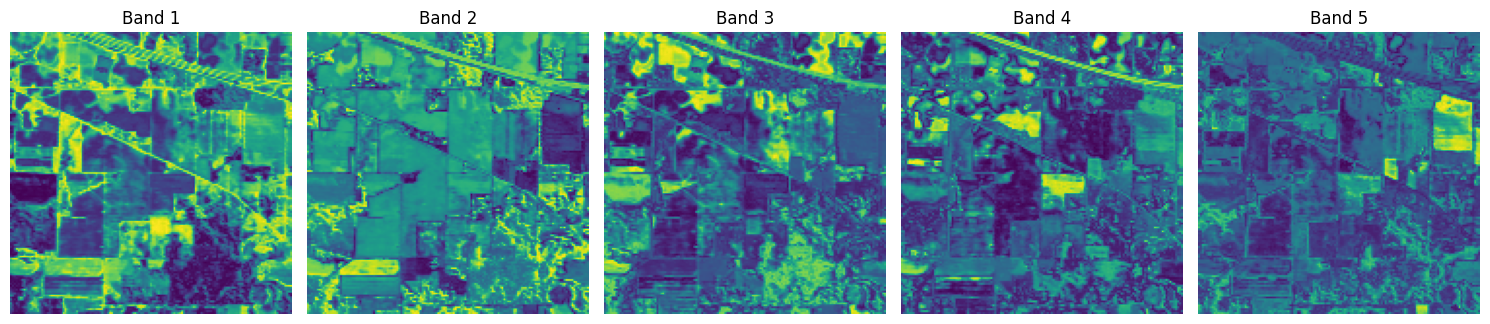

In [ ]:
bands_to_plot = [1, 2, 3, 4, 5] # Display any 5 bands

fig, axes = plt.subplots(1, len(bands_to_plot), figsize=(15, 5))

for i, band in enumerate(bands_to_plot):
    ax = axes[i]
    ax.imshow(KPCAbandFinalarray[:, :, band])
    ax.set_title(f'Band {band}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    print(margin)
    zeroPaddedX = padWithZeros(X, margin=margin)
    print(X.shape[0] * X.shape[1])
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
Feature_Image, Target = createImageCubes(KPCAbandFinalarray, groundtruth, windowSize = 25) # Set window size
print(Feature_Image.shape)
print(Target.shape)

12
21025
(10249, 25, 25, 15)
(10249,)


In [ ]:
from sklearn.model_selection import train_test_split
trainsize = 10 # Set training size. It should not exceed 5 for PU and SV dataset
testsize = ((100-trainsize)/100)
print(testsize)
Feature_Image1,Target1 = shuffle(Feature_Image,Target)
x_train, x_test, y_train, y_test = train_test_split(Feature_Image1,Target1,test_size=testsize,stratify=Target1)
YtrainFrame = pd.DataFrame(y_train,columns=['target'])
y = YtrainFrame['target']
z = y.value_counts(ascending=True)
yq = pd.DataFrame(z)
print("Final Training Samples ", yq )

0.9
Final Training Samples          count
target       
8.0         2
6.0         3
0.0         5
15.0        9
12.0       20
3.0        24
14.0       39
4.0        48
7.0        48
11.0       59
5.0        73
2.0        83
9.0        97
13.0      126
1.0       143
10.0      245


In [ ]:
windowSize = 25 # Enter window size
K = bands
x_train = x_train.reshape(-1, windowSize, windowSize, K, 1)
x_train.shape

(1024, 25, 25, 15, 1)

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_train.shape

(1024, 16)

In [ ]:
x_test = x_test.reshape(-1, windowSize, windowSize, K, 1)
print(x_test.shape)
y_test = to_categorical(y_test)
print(y_test.shape)

(9225, 25, 25, 15, 1)
(9225, 16)


In [ ]:
from keras import Sequential, layers
from keras.layers import Reshape

In [ ]:
model = Sequential()

model.add(layers.Conv3D(16, (3, 3, 3), activation='relu', input_shape=(windowSize,windowSize,K,1)))
model.add(layers.MaxPooling3D((2, 2, 2)))
model.add(layers.Conv3D(32, (3, 3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling3D((2, 2, 2)))
model.add(layers.Conv3D(64, (3, 3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling3D((2, 2, 2)))
#ANN
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(16, activation='softmax'))

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 23, 23, 13, 16)      │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 11, 11, 6, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 11, 11, 6, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 5, 5, 3, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 5, 5, 3, 64)         │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 2, 2, 1, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │           2,064 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 170,416 (665.69 KB)

 Trainable params: 170,416 (665.69 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define Optimizer
Adam(learning_rate=0.001, weight_decay=1e-06)
# Define loss, optimizer and metric
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [ ]:
  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='./logs', histogram_freq=1)

In [ ]:
filepath = "bestmodel.keras" # Define model name
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min', save_weights_only=False)  # Save entire model, not just weights
callbacks_list = [checkpoint]

In [ ]:
# Define batch size, epochs and validation split
history = model.fit(x_train, y_train, batch_size = 200, epochs = 250, validation_split = 0.0, verbose = 1, callbacks = callbacks_list)

Epoch 1/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1229 - loss: 2.7021  
Epoch 1: loss improved from inf to 2.64956, saving model to bestmodel.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.1253 - loss: 2.6946
Epoch 2/250
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2474 - loss: 2.4630
Epoch 2: loss improved from 2.64956 to 2.45736, saving model to bestmodel.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2417 - loss: 2.4614
Epoch 3/250
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2430 - loss: 2.3273
Epoch 3: loss improved from 2.45736 to 2.33842, saving model to bestmodel.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2397 - loss: 2.3305
Epoch 4/250
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2492 - loss: 2.2751
Epoch 4: loss improved from 2.33842 to 2.23978, saving model to bestmodel.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2547 - loss: 2.2603
Epoch 5/250
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy:

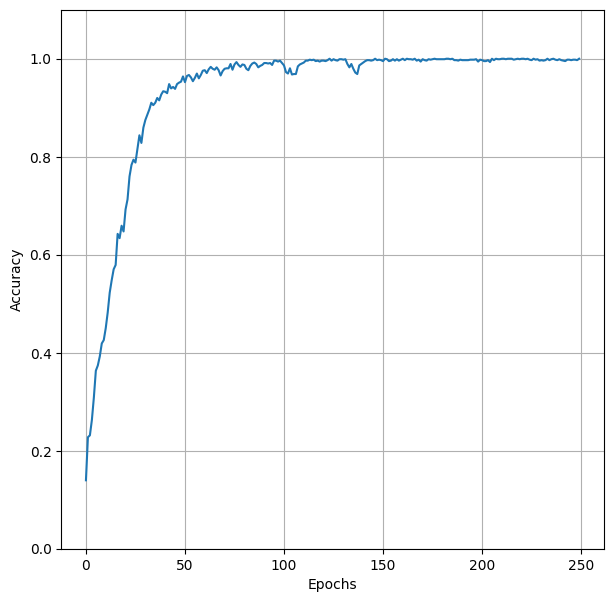

In [ ]:
plt.figure(figsize=(7,7))
plt.ylim(0,1.1)
plt.grid()
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
#plt.legend(['Training','Validation'])
plt.show()

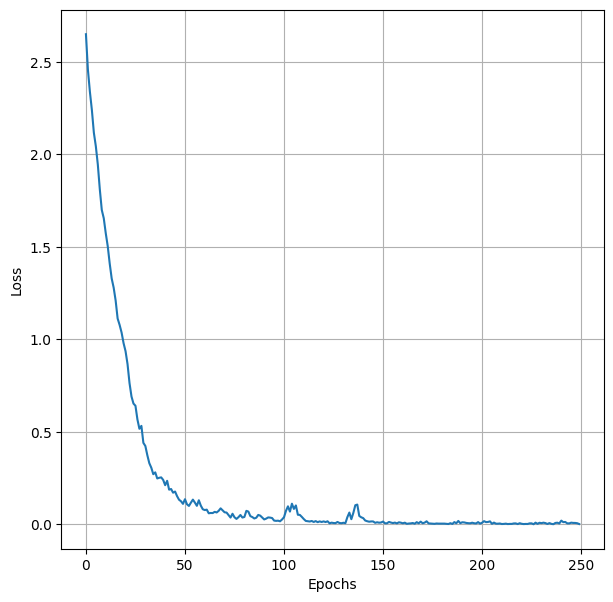

In [ ]:
plt.figure(figsize=(7,7))
plt.grid()
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
#plt.legend(['Training','Validation'], loc='upper right')
plt.show()

In [ ]:
model.load_weights("bestmodel.keras")  # Enter model name
# Define loss, optimizer and metric
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [ ]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
classification = classification_report(np.argmax(y_test, axis=1), y_pred)
print(classification)

289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        41
           1       0.99      0.97      0.98      1285
           2       1.00      0.99      0.99       747
           3       0.97      0.98      0.97       213
           4       0.96      0.97      0.96       435
           5       0.98      0.99      0.99       657
           6       0.96      1.00      0.98        25
           7       0.99      1.00      1.00       430
           8       1.00      0.89      0.94        18
           9       1.00      0.96      0.98       875
          10       0.98      0.98      0.98      2210
          11       0.98      0.99      0.99       534
          12       0.94      0.97      0.95       185
          13       0.96      1.00      0.98      1139
          14       0.99      1.00      0.99       347
          15       0.97      0.99      0.98        84

    accuracy                           

In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9815 - loss: 0.1408
0.9821138211382113
0.9796131818484088
0.9788310754294602
[0.87234043 0.99207607 0.99594046 0.97196262 0.9610984  0.98489426
 0.96153846 0.99307159 1.         1.         0.98277425 0.98320896
 0.93717277 0.96362098 0.98857143 0.96511628]


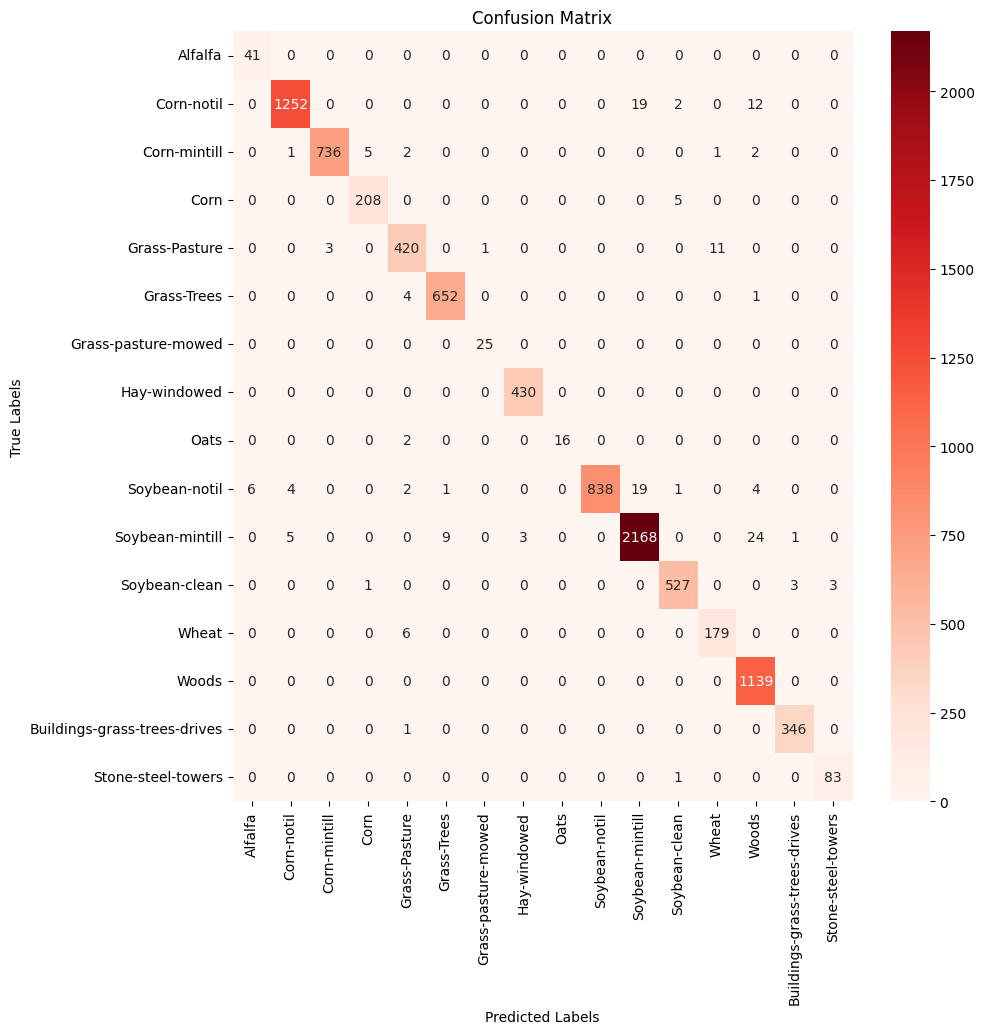

In [ ]:
oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
each_acc, aa = AA_andEachClassAccuracy(confusion)
kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
score = model.evaluate(x_test, y_test, batch_size=36)
Test_Loss =  score[0]*100
Test_accuracy = score[1]*100
print(oa)
print(kappa)
print(aa)
a = confusion.diagonal()/confusion.sum(axis=0)
print(a)
class_labels = ['Alfalfa', 'Corn-notil', 'Corn-mintill', 'Corn','Grass-Pasture','Grass-Trees','Grass-pasture-mowed','Hay-windowed','Oats','Soybean-notil','Soybean-mintill','Soybean-clean','Wheat','Woods','Buildings-grass-trees-drives','Stone-steel-towers']
plt.figure(figsize=(10,10))
sn.heatmap(confusion, annot=True, cmap=plt.cm.Reds, fmt="d",
           xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    return patch

height = groundtruth.shape[0]
width = groundtruth.shape[1]
PATCH_SIZE = 25
numComponents = K
X = padWithZeros(KPCAbandFinalarray, PATCH_SIZE//2)

In [ ]:
outputsRelu= np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(groundtruth[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
            predictionrelu = (model.predict(X_test_image))
            predictionrelu = np.argmax(predictionrelu, axis=1)
            outputsRelu[i][j] = predictionrelu+1

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


<ipython-input-37-54b33d62d237>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  outputsRelu[i][j] = predictionrelu+1


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

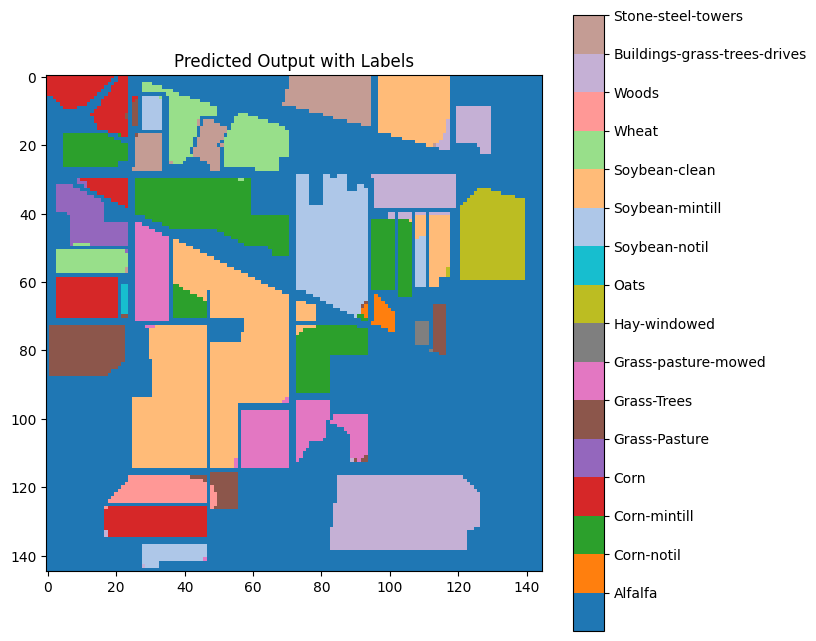

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define the class labels and custom color map (16 colors)
class_labels = ['Alfalfa', 'Corn-notil', 'Corn-mintill', 'Corn','Grass-Pasture','Grass-Trees','Grass-pasture-mowed','Hay-windowed','Oats','Soybean-notil','Soybean-mintill','Soybean-clean','Wheat','Woods','Buildings-grass-trees-drives','Stone-steel-towers']

# Custom color map with 16 distinct colors
cmap = ListedColormap([
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94'
])

# Display the predicted image using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(outputsRelu.astype(int), cmap=cmap)

# Add a color bar with the class labels
cbar = plt.colorbar(ticks=np.arange(1, len(class_labels) + 1))
cbar.ax.set_yticklabels(class_labels)

plt.title('Predicted Output with Labels')
plt.show()
